In [1]:
import datetime # для работы со времнем
import gc # сборщик мусора

import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score

from lightgbm import LGBMRegressor
 

%matplotlib inline

# 1. Чтение данных

In [2]:
df = pd.read_csv('/kaggle/input/realestatepriceprediction/train.csv')

X = df.drop('Price', axis=1)
y = df[['Price']]

X_final = pd.read_csv('/kaggle/input/realestatepriceprediction/test.csv')

# сразу создам
#  копируют ID из теста в df preds_final
preds_final = pd.DataFrame()
preds_final['Id'] = X_final['Id'].copy()

# заменили штатный Id на ID дынный сетом данных и индексировали по этому столбу
X.set_index('Id', inplace=True)
X_final.set_index('Id', inplace=True)

print('Строк в трейне:' ,  X.shape[0])
print('Строк в тесте', X_final.shape[0])

# Удалим ненужные файлы
del df
gc.collect()  

Строк в трейне: 10000
Строк в тесте 5000


4

In [3]:
X.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
Id,,,,,,,,,,,,,,,,,,
14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B
15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B
4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B
5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B
10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B


In [4]:
X['DistrictId'] = X['DistrictId'].astype(str)
X_final['DistrictId'] = X_final['DistrictId'].astype(str)

## 1. Минимальный EDA

### 1.1 Выбросы

### Заполнение NaN

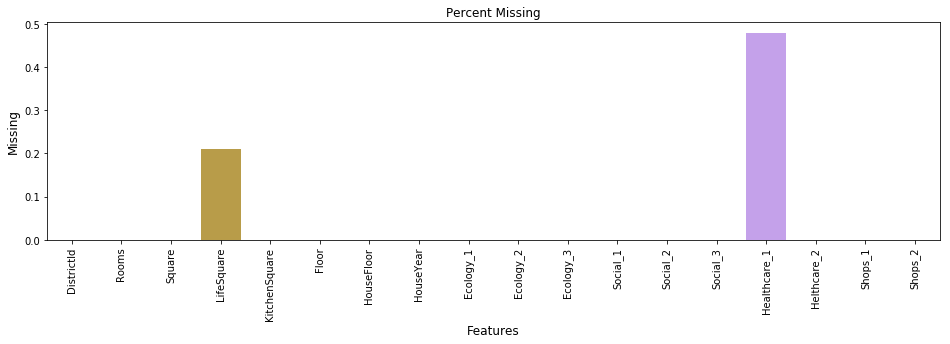

In [5]:
import seaborn as sns

nan_df = (X.isna().sum() / X.shape[0]).reset_index()
nan_df.columns=['feature', 'nan_percent']

plt.figure(figsize=(16,4))
sns.barplot(nan_df['feature'], nan_df['nan_percent'])
plt.title('Percent Missing')
plt.ylabel('Missing', fontsize=12)
plt.xlabel('Features', fontsize=12)
plt.xticks(rotation=90)
plt.show()

# Удалим Healthcare_1
# Заполним LifeSquare

### 1.2 Feature engineering

**DistrictId**

In [6]:
X.DistrictId.nunique()

205

In [7]:
dict(X['DistrictId'].value_counts())

{'27': 851,
 '1': 652,
 '23': 565,
 '6': 511,
 '9': 294,
 '62': 247,
 '30': 228,
 '58': 179,
 '53': 174,
 '21': 165,
 '52': 143,
 '8': 142,
 '11': 129,
 '46': 119,
 '61': 118,
 '45': 116,
 '74': 114,
 '34': 111,
 '57': 107,
 '44': 104,
 '99': 97,
 '47': 97,
 '13': 97,
 '101': 97,
 '7': 92,
 '48': 90,
 '94': 89,
 '29': 89,
 '41': 87,
 '3': 82,
 '84': 80,
 '28': 79,
 '22': 78,
 '2': 78,
 '25': 77,
 '85': 76,
 '93': 73,
 '90': 72,
 '37': 72,
 '96': 71,
 '59': 67,
 '75': 66,
 '26': 65,
 '12': 64,
 '128': 64,
 '88': 64,
 '66': 62,
 '67': 61,
 '17': 59,
 '55': 58,
 '39': 57,
 '10': 56,
 '105': 55,
 '31': 55,
 '18': 51,
 '111': 49,
 '119': 49,
 '0': 48,
 '78': 46,
 '91': 44,
 '63': 43,
 '124': 43,
 '129': 43,
 '42': 42,
 '79': 42,
 '113': 41,
 '109': 41,
 '77': 40,
 '54': 37,
 '38': 36,
 '15': 36,
 '24': 35,
 '32': 34,
 '56': 34,
 '5': 34,
 '103': 33,
 '123': 32,
 '19': 31,
 '80': 31,
 '33': 31,
 '83': 31,
 '130': 29,
 '69': 29,
 '138': 29,
 '64': 28,
 '86': 27,
 '87': 27,
 '70': 27,
 '108': 

# 2. Очистка данных

In [8]:
class FeatureImputer:
    """Заполнение пропусков и обработка выбросов"""
    
    def __init__(self):
        self.medians=None
        #  НЕ ПОНЯЛ ЗАЧЕМ?
        
    def fit(self, X):
        self.medians = X.median()
        #  медианы каждого столбца
        
    def transform(self, X):
        
        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        X.loc[X['Rooms'] < 1, 'Rooms'] = 1
#         X.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms'] # !!! медиана посчитана на трейне !!!



        
        # KitchenSquare
        X['KitchenSquare_outlier'] = 0
        X.loc[(X['KitchenSquare'] < 3) | (X['KitchenSquare'] > 500),'KitchenSquare_outlier'] = 1
#         X.loc[X['KitchenSquare'] > 500, 'KitchenSquare','KitchenSquare_outlier'] = 1
#         X.loc[X['KitchenSquare'] > 1000, 'KitchenSquare'] = X.loc[X['KitchenSquare'] > 1000, 'KitchenSquare'] / 10  # можно median
        
        X['KitchenSquare_outlier2'] = 0
        X.loc[(X['LifeSquare']//X['KitchenSquare'])<1,'KitchenSquare_outlier2'] = 1
        X.loc[(X['LifeSquare']//X['KitchenSquare'])<1,'KitchenSquare'] = self.medians['KitchenSquare']
        
        X['KitchenSquare_outlier3'] = 0
        X.loc[(X['KitchenSquare'] - X['KitchenSquare'].mean()).abs() > 3 * X['KitchenSquare'].std(), 'KitchenSquare_outlier3'] = 1
 
        X['KitchenSquare_outlier4'] = 0
        X.loc[X['Square'] < X['KitchenSquare'], 'KitchenSquare_outlier4'] = 1
        X.loc[X['Square'] < X['KitchenSquare'], 'KitchenSquare'] = self.medians['KitchenSquare']
    
    
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = 1 #self.medians['HouseFloor']
        
        X['HouseFloor_outlier2'] = 0
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier2'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'Floor'] = X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor']
        
        
        
        # HouseYear
        current_year = now = datetime.datetime.now().year
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        
        
        
#         Square
        X['Square_outlier'] = 0
        X.loc[X['Square'] < X['LifeSquare'], 'Square_outlier'] = 1
        X.loc[X['Square'] < X['LifeSquare'], 'Square'] = X['LifeSquare'] + X['KitchenSquare']
        
        X['Square_outlier2'] = 0
        X.loc[X['Square'] > 1000, 'Square_outlier2'] = 1
        X.loc[X['Square'] > 1000, 'Square'] = self.medians['Square']
        
        X['Square_outlier3'] = 0
        X.loc[(X['Square'] - X['Square'].mean()).abs() > 3 * X['Square'].std(), 'Square_outlier3'] = 1
    
    

#   LifeSquare  
        X['LifeSquare_outlier'] = 0
        X.loc[(X['LifeSquare'] - X['LifeSquare'].mean()).abs() > 3 * X['LifeSquare'].std(), 'LifeSquare_outlier'] = 1
    
# Доля жилой площади в общей площади
        X['LifeSquare_share'] = X['LifeSquare'] / X['Square'] * 100

# Доля площади кухни в общей площади
        X['KitchenSquare_share'] = X['KitchenSquare'] / X['Square']* 100    
    
# Доля этажа в общей высоте дома
        X['Floor_in the house'] = X['Floor'] / X['HouseFloor']* 100
    
# Площадь комнаты
        X['Room_square'] = X['LifeSquare'] / X['Rooms']
    
        
        
    
        # Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
            
        # LifeSquare
#         0 или 1 в столбе, где была инфа и где отсутствовала
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        
#         только в случае если все 3 данные присутствуют будет работать формула ниже
        condition = (X['LifeSquare'].isna()) &\
                      (~X['Square'].isna()) & \
                      (~X['KitchenSquare'].isna())
        
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - 3
        
        
        return X

In [9]:
imputer = FeatureImputer()

imputer.fit(X) # расчет медиан

X = imputer.transform(X)
X_final = imputer.transform(X_final)

# 3. Feature engineering

In [10]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 14038 to 6306
Data columns (total 34 columns):
DistrictId                10000 non-null object
Rooms                     10000 non-null float64
Square                    10000 non-null float64
LifeSquare                10000 non-null float64
KitchenSquare             10000 non-null float64
Floor                     10000 non-null float64
HouseFloor                10000 non-null float64
HouseYear                 10000 non-null int64
Ecology_1                 10000 non-null float64
Ecology_2                 10000 non-null object
Ecology_3                 10000 non-null object
Social_1                  10000 non-null int64
Social_2                  10000 non-null int64
Social_3                  10000 non-null int64
Helthcare_2               10000 non-null int64
Shops_1                   10000 non-null int64
Shops_2                   10000 non-null object
Rooms_outlier             10000 non-null int64
KitchenSquare_outlier   

In [11]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        self.med_price_by_floor_year = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # DistrictID
        district = X['DistrictId'].value_counts()
        district = district[district > 50]  ## Если вы этого не сделаете, то на Leaderboard-е улетите в самый низ (>100 места, R2 ~ 0.65),
                                           ## Хотя на локальной валидации скор вырастет
        
        self.DistrictId_counts = dict(district)
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # Target encoding
        ## District
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            df['DistrictId_popular'] = df['DistrictId'].copy()
            df.loc[~df['DistrictId_popular'].isin(district.keys().tolist())] = np.nan
            
            self.med_price_by_district = df.groupby(['DistrictId_popular', 'Rooms'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByDistrict',
                                                           'DistrictId_popular': 'DistrictId'})
            
        ## floor, year
        if y is not None:
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                                        rename(columns={'Price':'MedPriceByFloorYear'})
        

        
    def transform(self, X):
        
        # DistrictId
        X['DistrictId_count'] = X['DistrictId'].map(self.DistrictId_counts)  # self.DistrictId_counts = {'id': value}
        
        X['new_district'] = 0
        X.loc[X['DistrictId_count'].isna(), 'new_district'] = 1
        
        X['DistrictId_count'].fillna(5, inplace=True)
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # More categorical features
        X = self.floor_to_cat(X)  # + столбец floor_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        
        # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
        
        return X
    
    @staticmethod
    def floor_to_cat(X):
        X['floor_cat'] = np.nan
        
        X.loc[X['Floor'] < 3, 'floor_cat'] = 1  
        X.loc[(X['Floor'] >= 3) & (X['Floor'] <= 5), 'floor_cat'] = 2
        X.loc[(X['Floor'] > 5) & (X['Floor'] <= 9), 'floor_cat'] = 3
        X.loc[(X['Floor'] > 9) & (X['Floor'] <= 15), 'floor_cat'] = 4
        X.loc[X['Floor'] > 15, 'floor_cat'] = 5
            
        return X
    @staticmethod
    def year_to_cat(X):
        
        X['year_cat'] = np.nan
        
        X.loc[X['HouseYear'] < 1941, 'year_cat'] = 1
        X.loc[(X['HouseYear'] >= 1941) & (X['HouseYear'] <= 1945), 'year_cat'] = 2
        X.loc[(X['HouseYear'] > 1945) & (X['HouseYear'] <= 1980), 'year_cat'] = 3
        X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 2000), 'year_cat'] = 4
        X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 5
        X.loc[(X['HouseYear'] > 2010), 'year_cat'] = 6
            
        return X
            

In [12]:
features = FeatureGenetator()

features.fit(X, y)

X = features.transform(X)
X_final = features.transform(X_final)


In [13]:
X.columns

Index(['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor',
       'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2', 'Ecology_3',
       'Social_1', 'Social_2', 'Social_3', 'Helthcare_2', 'Shops_1', 'Shops_2',
       'Rooms_outlier', 'KitchenSquare_outlier', 'KitchenSquare_outlier2',
       'KitchenSquare_outlier3', 'KitchenSquare_outlier4',
       'HouseFloor_outlier', 'HouseFloor_outlier2', 'HouseYear_outlier',
       'Square_outlier', 'Square_outlier2', 'Square_outlier3',
       'LifeSquare_outlier', 'LifeSquare_share', 'KitchenSquare_share',
       'Floor_in the house', 'Room_square', 'LifeSquare_nan',
       'DistrictId_count', 'new_district', 'floor_cat', 'year_cat',
       'MedPriceByDistrict', 'MedPriceByFloorYear'],
      dtype='object')

In [14]:
remain_features = [ 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor',
       'HouseFloor', 'HouseYear', 'Ecology_1', 'Ecology_2', 'Ecology_3',
       'Social_1', 'Social_2', 'Social_3', 'Helthcare_2', 'Shops_1', 'Shops_2',
        'HouseFloor_outlier2', 'HouseYear_outlier',
       'Square_outlier', 'Square_outlier3', 'LifeSquare_share', 'KitchenSquare_share',
       'Floor_in the house', 'Room_square',
       'DistrictId_count',
       'MedPriceByDistrict', 'MedPriceByFloorYear']

X = X[remain_features]
X_final = X_final[remain_features]

# 4. Модель

In [15]:
model = LGBMRegressor(max_depth=7,
                             min_samples_leaf=30,
                             n_estimators=300,
                             random_state=42)

cv_score = cross_val_score(model, X, y, 
                           scoring='r2', 
                           cv=KFold(n_splits=5, shuffle=True, random_state=42))
# cv_score
mean = cv_score.mean()
std = cv_score.std()

print('R2: {:.3f} +- {:.3f}'.format(mean, std))

R2: 0.743 +- 0.021


In [16]:
# Обучаю модель на всем трейне
model.fit(X, y)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=7,
              min_child_samples=20, min_child_weight=0.001, min_samples_leaf=30,
              min_split_gain=0.0, n_estimators=300, n_jobs=-1, num_leaves=31,
              objective=None, random_state=42, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

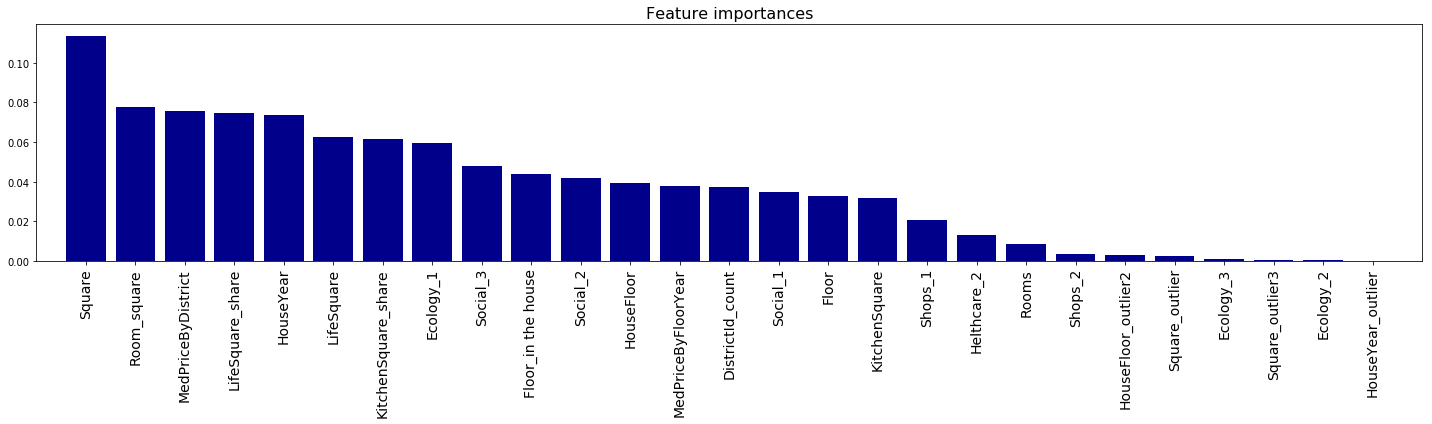

In [17]:
def plot_feature_importances(importances, X):
    
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize = (20, 6))
    plt.title("Feature importances", fontsize=16)
    plt.bar(range(X.shape[1]), importances[indices] / importances.sum(),
           color="darkblue", align="center")
    plt.xticks(range(X.shape[1]), X.columns[indices], rotation = 90, fontsize=14)
    plt.xlim([-1, X.shape[1]])

    plt.tight_layout()
    # plt.savefig('fe.jpg')
    plt.show()
    
plot_feature_importances(importances = model.feature_importances_, X=X)

In [18]:
y_pred_final = model.predict(X_final)

preds_final['Price'] = y_pred_final
preds_final.to_csv('predictions.csv', index=False)

preds_final.head()

,Id,Price
0,725,151274.652444
1,15856,229438.703310
2,5480,159513.755744
3,15664,283270.547584
4,14275,140501.354004


In [19]:
preds_final.shape

(5000, 2)